In [1]:
import numpy as np
import tensorflow as tf
import struct
import chess
import functools
from enum import Enum
from enum import IntFlag

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

FEATURE_TRANSFORMER_HALF_DIMENSIONS = 256
DENSE_LAYERS_WIDTH = 32

print(tf.config.list_physical_devices('GPU'))
print(tf.__version__)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
2.2.0


In [2]:
import urllib

req = urllib.request.Request(
    'https://tests.stockfishchess.org/api/nn/nn-daab97be77a2.nnue', 
    data=None, 
    headers={
        'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/35.0.1916.47 Safari/537.36'
    }
)

filedata = urllib.request.urlopen(req)
datatowrite = filedata.read()

with open('./network.nnue', 'wb') as f:
    f.write(datatowrite)

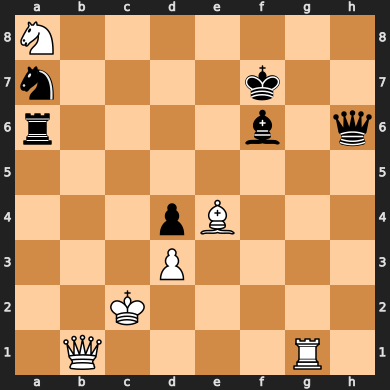

In [3]:
board = chess.Board('N7/n4k2/r4b1q/8/3pB3/3P4/2K5/1Q4R1 w - - 0 1')
board

In [4]:
SQUARE_NB = 64

class PieceSquare(IntFlag):
  NONE     =  0,
  W_PAWN   =  1,
  B_PAWN   =  1 * SQUARE_NB + 1
  W_KNIGHT =  2 * SQUARE_NB + 1
  B_KNIGHT =  3 * SQUARE_NB + 1
  W_BISHOP =  4 * SQUARE_NB + 1
  B_BISHOP =  5 * SQUARE_NB + 1
  W_ROOK   =  6 * SQUARE_NB + 1
  B_ROOK   =  7 * SQUARE_NB + 1
  W_QUEEN  =  8 * SQUARE_NB + 1
  B_QUEEN  =  9 * SQUARE_NB + 1
  W_KING   = 10 * SQUARE_NB + 1
  END      = W_KING # pieces without kings (pawns included)
  B_KING   = 11 * SQUARE_NB + 1
  END2     = 12 * SQUARE_NB + 1

  def from_piece(p: chess.Piece, is_white_pov: bool):
    return {
        chess.WHITE: {
            chess.PAWN: PieceSquare.W_PAWN,
            chess.KNIGHT: PieceSquare.W_KNIGHT,
            chess.BISHOP: PieceSquare.W_BISHOP,
            chess.ROOK: PieceSquare.W_ROOK,
            chess.QUEEN: PieceSquare.W_QUEEN,
            chess.KING: PieceSquare.W_KING
        },
        chess.BLACK: {
            chess.PAWN: PieceSquare.B_PAWN,
            chess.KNIGHT: PieceSquare.B_KNIGHT,
            chess.BISHOP: PieceSquare.B_BISHOP,
            chess.ROOK: PieceSquare.B_ROOK,
            chess.QUEEN: PieceSquare.B_QUEEN,
            chess.KING: PieceSquare.B_KING
        }
    }[p.color == is_white_pov][p.piece_type]

def orient(is_white_pov: bool, sq: int):
  # Use this one for "flip" instead of "rotate"
  # return (chess.A8 * (not is_white_pov)) ^ sq
  return (63 * (not is_white_pov)) ^ sq

def make_halfkp_index(is_white_pov: bool, king_sq: int, sq: int, p: chess.Piece):
  return orient(is_white_pov, sq) + PieceSquare.from_piece(p, is_white_pov) + PieceSquare.END * king_sq

# Returns SparseTensors
def get_halfkp_indeces(board: chess.Board):
  result = []
  is_white_pov = board.turn
  for i, turn in enumerate([board.turn, not board.turn]):
    indices = []
    values = []
    for sq, p in board.piece_map().items():
      if p.piece_type == chess.KING:
        continue
      indices.append([0, make_halfkp_index(turn, orient(turn, board.king(turn)), sq, p)])
      values.append(1)
    result.append(tf.sparse.reorder(tf.sparse.SparseTensor(indices=indices, values=values, dense_shape=[1, 41024])))
  return result

get_halfkp_indeces(board)[0].shape


TensorShape([1, 41024])

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 41024)]      0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 41024)]      0                                            
__________________________________________________________________________________________________
feature_transformer (Dense)     (None, 256)          10502400    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 256)          0           feature_transformer[0][0]    

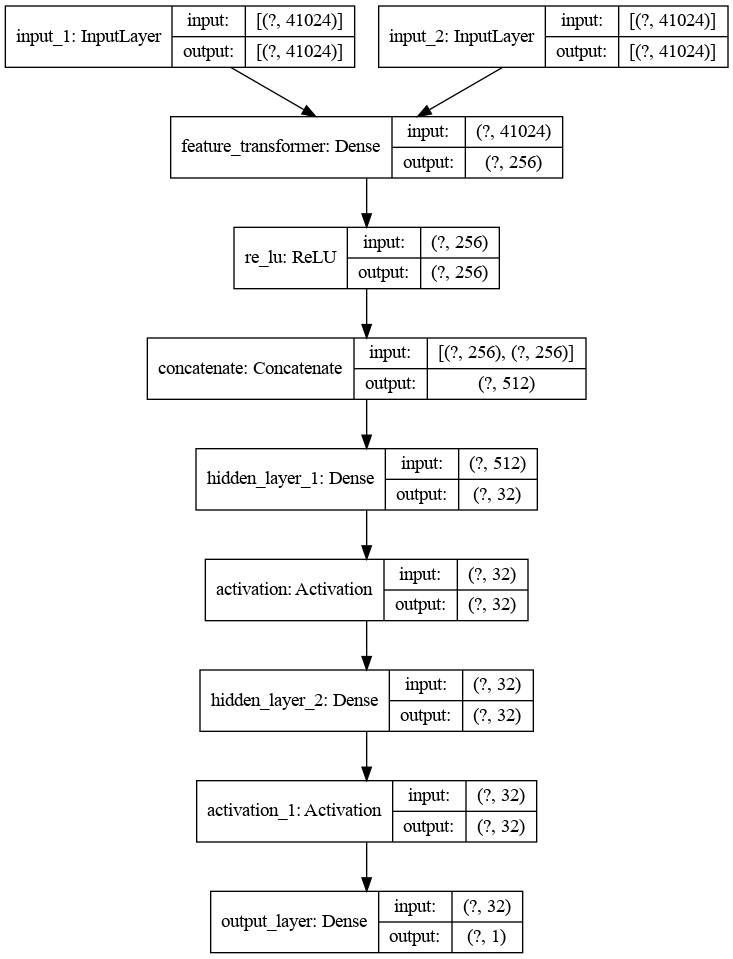

In [5]:
def build_model_inputs():
  return keras.Input(shape=(41024,), sparse=True, dtype=tf.int8), keras.Input(shape=(41024,), sparse=True, dtype=tf.int8)

# Feature transformer layer takes 2 input vectors, forwards them through a Dense
# layer and finally merges the result using Concatenate.
def build_feature_transformer(inputs1, inputs2):
  ft_dense_layer = layers.Dense(FEATURE_TRANSFORMER_HALF_DIMENSIONS, name='feature_transformer')
  clipped_relu = layers.ReLU(max_value=127)
  transformed1 = clipped_relu(ft_dense_layer(inputs1))
  transformed2 = clipped_relu(ft_dense_layer(inputs2))
  return tf.keras.layers.Concatenate()([transformed1, transformed2])

# NNUE ReLU formula is: f(x) = max(0, min(127, x / 64))
def nnue_relu(x):
    return tf.maximum(0, tf.minimum(127, tf.dtypes.cast(tf.math.floordiv(x, 64), tf.int32)))
    # return tf.maximum(0.0, tf.minimum(127.0, tf.math.divide(x, 64)))

def build_hidden_layers(inputs):
  hidden_layer_1 = layers.Dense(DENSE_LAYERS_WIDTH, name='hidden_layer_1')
  hidden_layer_2 = layers.Dense(DENSE_LAYERS_WIDTH, name='hidden_layer_2')
  # activation_1 = layers.ReLU(max_value=127)
  # activation_2 = layers.ReLU(max_value=127)
  activation_1 = layers.Activation(nnue_relu)
  activation_2 = layers.Activation(nnue_relu)
  return activation_2(hidden_layer_2(activation_1(hidden_layer_1(inputs))))

def build_output_layer(inputs):
  output_layer = layers.Dense(1, name='output_layer')
  return output_layer(inputs)

def build_model():
  inputs1, inputs2 = build_model_inputs()
  outputs = build_output_layer(build_hidden_layers(build_feature_transformer(inputs1, inputs2)))
  return keras.Model(inputs=[inputs1, inputs2], outputs=outputs)

model = build_model()

# Model summary
print(model.summary())

# Plot model graph
keras.utils.plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
from IPython.display import Image
Image(retina=True, filename='model.png')

In [6]:
def nn_value_to_centipawn(nn_value):
  return (((nn_value // 16) * 100) // 208) / 100

def read_feature_transformer_parameters(nn_file, model):
  [header] = np.fromfile(nn_file, dtype=np.uint32, count=1)
  ASSOCIATED_HALFKP_KING = 1 # From C++: "(AssociatedKing == Side::kFriend)"
  OUTPUT_DIMENSIONS = 2 * FEATURE_TRANSFORMER_HALF_DIMENSIONS
  HASH_VALUE = (0x5D69D5B9 ^ ASSOCIATED_HALFKP_KING) ^ OUTPUT_DIMENSIONS
  assert header == HASH_VALUE

  biases = np.fromfile(nn_file, dtype=np.int16, count=FEATURE_TRANSFORMER_HALF_DIMENSIONS)
  weights = np.fromfile(nn_file, dtype=np.int16, count=FEATURE_TRANSFORMER_HALF_DIMENSIONS*41024)

  feature_transformer = model.get_layer(name='feature_transformer')
  feature_transformer.set_weights([weights.reshape((41024,-1)), biases])

def read_network_parameters(nn_file, model):
  _header = np.fromfile(nn_file, dtype=np.uint32, count=1)
  
  biases1 = np.fromfile(nn_file, dtype=np.int32, count=32)
  weights1 = np.fromfile(nn_file, dtype=np.int8, count=32*512)
  hidden_layer_1 = model.get_layer(name='hidden_layer_1')
  hidden_layer_1.set_weights([weights1.reshape((512,32), order='F'), biases1])

  biases2 = np.fromfile(nn_file, dtype=np.int32, count=32)
  weights2 = np.fromfile(nn_file, dtype=np.int8, count=32*32)
  hidden_layer_2 = model.get_layer(name='hidden_layer_2')
  hidden_layer_2.set_weights([weights2.reshape((32,32), order='F'), biases2])

  biases3 = np.fromfile(nn_file, dtype=np.int32, count=1)
  weights3 = np.fromfile(nn_file, dtype=np.int8, count=32)
  output_layer = model.get_layer(name='output_layer')
  output_layer.set_weights([weights3.reshape((32,1), order='F'), biases3])

  current_pos = nn_file.tell()
  nn_file.seek(0, 2)
  assert nn_file.tell() - current_pos == 0

with open('./network.nnue', 'rb') as nn_file:
  [version] = np.fromfile(nn_file, dtype=np.uint32, count=1)
  [hash_value] = np.fromfile(nn_file, dtype=np.uint32, count=1)
  [size] = np.fromfile(nn_file, dtype=np.uint32, count=1)
  print(f'Version: {version}')
  print(f'Hash: {hash_value}')
  print(f'Architecture: {nn_file.read(size).decode()}')

  model = build_model()

  read_feature_transformer_parameters(nn_file, model)
  read_network_parameters(nn_file, model)

  prediction = model.predict(get_halfkp_indeces(chess.Board()))[0][0]
  print(f'Start position prediction: {nn_value_to_centipawn(prediction)}')

  prediction = model.predict(get_halfkp_indeces(chess.Board('rnb1kbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1')))[0][0]
  print(f'Position with big white advantage prediction: {nn_value_to_centipawn(prediction)}')

  prediction = model.predict(get_halfkp_indeces(chess.Board('rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNB1KBNR w KQkq - 0 1')))[0][0]
  print(f'Position with big black advantage prediction: {nn_value_to_centipawn(prediction)}')

Version: 2062757654
Hash: 1046128366
Architecture: Features=HalfKP(Friend)[41024->256x2],Network=AffineTransform[1<-32](ClippedReLU[32](AffineTransform[32<-32](ClippedReLU[32](AffineTransform[32<-512](InputSlice[512(0:512)])))))
Start position prediction: 0.19
Position with big white advantage prediction: 10.62
Position with big black advantage prediction: -4.97


In [7]:
# Testing

from keras import backend as K
input1 = model.input               # input placeholder
output1 = [layer.output for layer in model.layers]# all layer outputs
fun = K.function(input1,output1)# evaluation function

layer_outputs = fun([t, 1.])

print("\nTransformed features:")
print(layer_outputs[4])

print("\nFirst dense layer output:")
print(layer_outputs[5])

print("\nClipped ReLU 1:")
print(layer_outputs[6])

print("\nSecond dense layer output:")
print(layer_outputs[7])

print("\nClipped ReLU 2:")
print(layer_outputs[8])

print("\nFinal output:")
print(layer_outputs[9])

Using TensorFlow backend.


NameError: name 't' is not defined